In [1]:
import pandas as pd
import os.path as op
import seaborn as sns
import matplotlib.pyplot as plt

bids_folder = '/data/ds-risk'

In [2]:
pupil = pd.read_csv(op.join(bids_folder, 'derivatives', 'pupil', 'model-n1_n2_n', 'pupil_pre_post12.tsv'), sep='\t', index_col=[0,1,2,3])

In [3]:
corrs = pupil.unstack(['event type', 'prepost']).pupil.groupby('subject').apply(lambda d: d.corr()).groupby(['event type', 'prepost']).mean()
corrs

event type                 n1                            n2
prepost                  post  post-pre       pre      post
event type prepost                                         
n1         post      1.000000  0.433387  0.507632 -0.006404
           post-pre  0.433387  1.000000 -0.540380  0.093955
           pre       0.507632 -0.540380  1.000000 -0.094501
n2         post     -0.006404  0.093955 -0.094501  1.000000

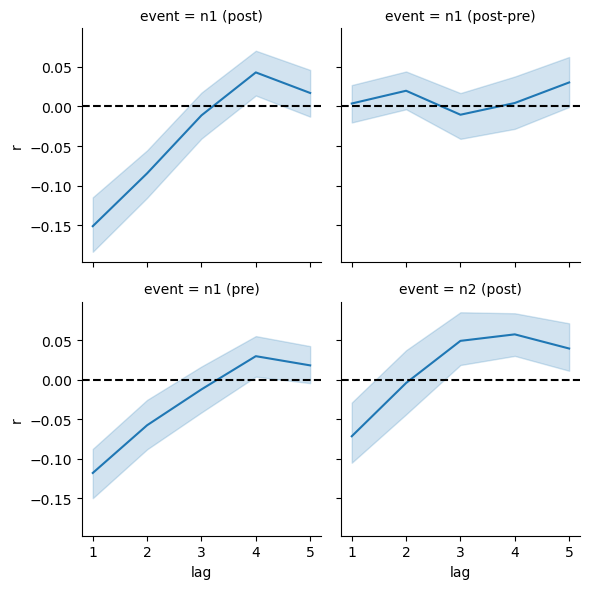

In [4]:

ars = []

lags = range(1, 6)

for lag in lags:
    ars.append(pupil.groupby(['subject', 'event type', 'prepost'])['pupil'].apply(lambda d: d.autocorr(lag=lag)))

ars = pd.concat(ars, keys=lags, names=['lag']).to_frame('r')

ars = ars.reset_index()

ars['event'] = ars.apply(lambda row: f'{row["event type"]} ({row.prepost})', axis=1)

fac = sns.FacetGrid(ars, col='event', col_wrap=2)
fac.map(sns.lineplot, 'lag', 'r', errorbar=('ci', 95))

fac.map(lambda *ars,**kwargs: plt.axhline(0.0, c='k', ls='--'))

In [5]:
from risk_experiment.utils import get_all_subjects


decoding_info = pd.concat([sub.get_decoding_info('3t2', mask='npcr', n_voxels=0.0) for sub in get_all_subjects(bids_folder)])

/Users/gdehol/mambaforge/lib/python3.10/site-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '


In [6]:
decoding_info.index = decoding_info.index.set_levels(decoding_info.index.levels[0].astype(int), level='subject')

In [7]:
df = pupil.join(decoding_info)

In [11]:
df['event'] = df.reset_index().apply(lambda row: f'{row["event type"]} ({row.prepost})', 1).values

In [12]:
import pingouin

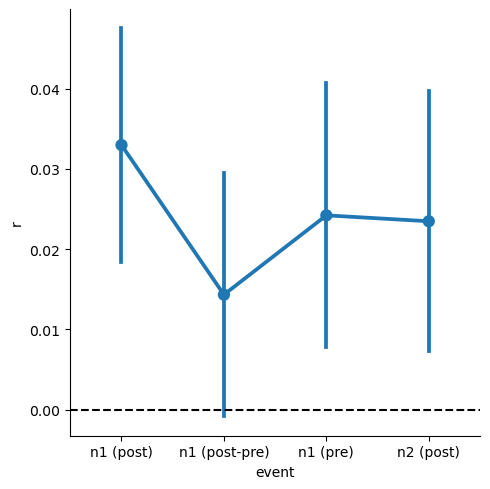

In [18]:
r = df.groupby(['subject', 'event type', 'prepost','event']).apply(lambda d: pingouin.corr(d['E'], d['pupil']))

sns.catplot(r.reset_index(), x='event', y='r', kind='point', errorbar='se')
plt.axhline(0.0, c='k', ls='--')

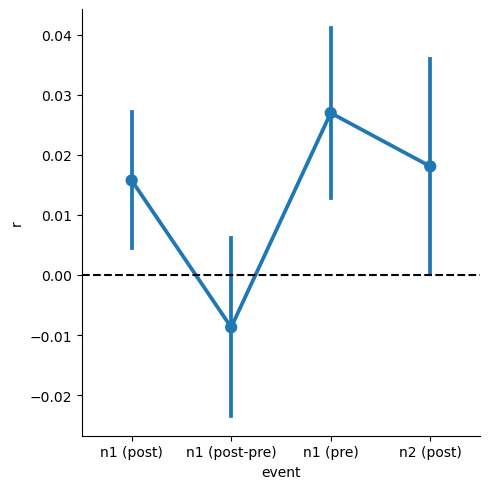

In [14]:
r = df.groupby(['subject', 'event type', 'prepost','event']).apply(lambda d: pingouin.corr(d['sd'], d['pupil']))

sns.catplot(r.reset_index(), x='event', y='r', kind='point', errorbar='se')
plt.axhline(0.0, c='k', ls='--')

In [20]:
import bambi as bmb

traces = []
keys = []

for event, d in df.groupby('event'):
    model = bmb.Model('sd ~ pupil + (pupil|subject)', data=d.reset_index())
    idata = model.fit(cores=1)
    traces.append(traces)
    keys.append(event)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 25 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 28 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 30 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


In [ ]:
id

In [11]:
import bambi as bmb

model = bmb.Model('sd ~ pupil + (pupil|subject)', data=df.xs('n1', 0, 'event type').xs('pre', 0, 'prepost').reset_index())
idata = model.fit(cores=1)

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 30 seconds.


In [12]:
import arviz as az

<Axes: title={'center': 'pupil'}>

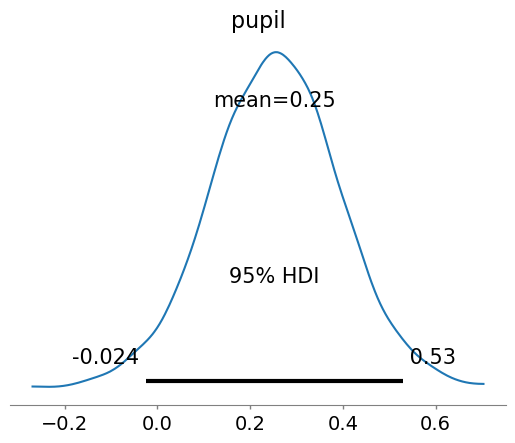

In [13]:
az.plot_posterior(idata.posterior, var_names=['pupil'], hdi_prob=.95)

In [ ]:
r = df.groupby(['subject', 'event type', 'prepost']).apply(lambda d: pingouin.corr(d['sd'], d['pupil']))

sns.catplot(r.reset_index(), x='event type', hue='prepost', y='r', kind='point', errorbar='se')
plt.axhline(0.0, c='k', ls='--')

In [23]:
import bambi as bmb

model = bmb.Model('sd ~ pupil + (pupil|subject)', data=df.xs('n1', 0, 'event type').xs('pre', 0, 'post-pre').reset_index())
idata = model.fit(cores=1)

In [19]:
df['q(pupil)'] = df.groupby(['subject', 'event type', 'prepost'], group_keys=False)['pupil'].apply(lambda x: pd.qcut(x, 5, labels=['q1', 'q2', 'q3', 'q4', 'q5']))

In [20]:
df['event'] = df.reset_index().apply(lambda row: f'{row["event type"]} ({row.prepost})', 1).values

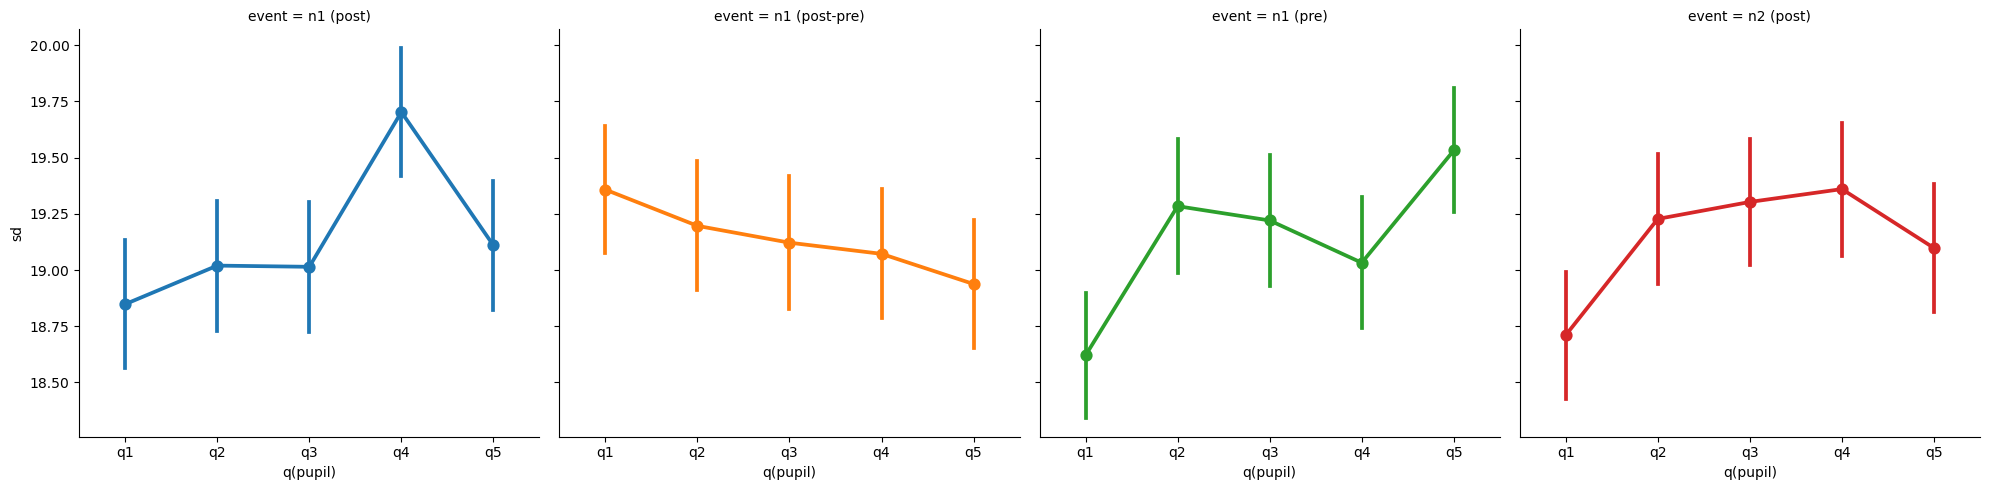

In [22]:
sns.catplot(data=df, x='q(pupil)', y='sd', hue='event', kind='point', col='event', errorbar='se')

In [ ]:
model = bmb.Model('sd ~ pupil + (pupil|subject)', data=df.xs('n1', 0, 'event type').xs('pre', 0, 'prepost').reset_index())
idata = model.fit(cores=1)